In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Import

In [112]:
lda = pd.read_csv("news_data/lda.csv")
tfidf = pd.read_csv("news_data/tfidf_snippet.csv")
sentiment = pd.read_csv("news_data/sentiment.csv")

In [113]:
columns_to_drop = ['headline.main', 'snippet', 'headline_lemmas', 'snippet_lemmas', 'Headline_Topic_0', 'Headline_Topic_1', 'Headline_Topic_2', 'Headline_Topic_3', 'Headline_Topic_4', 'Headline_Topic_5', 'Headline_Topic_6', 'Headline_Topic_7',	'Headline_Topic_8',	'Headline_Topic_9']
lda = lda.drop(columns=columns_to_drop)

In [114]:
columns_to_drop = ['headline.main', 'snippet', 'headline_lemmas', 'snippet_lemmas', 'headline_VADER', 'headline_AFINN']
sentiment = sentiment.drop(columns=columns_to_drop)

In [115]:
df = pd.merge(lda, tfidf, on='pub_date')
df = pd.merge(df, sentiment, on='pub_date')

In [116]:
df.rename(columns={'pub_date': 'Date'}, inplace=True)

In [117]:
AAPL = pd.read_csv("stock_data/AAPL_stock.csv")

In [118]:
df = pd.merge(df, AAPL, on='Date')

In [119]:
df.head()

,Date,Snippet_Topic_0,Snippet_Topic_1,Snippet_Topic_2,Snippet_Topic_3,Snippet_Topic_4,Snippet_Topic_5,Snippet_Topic_6,Snippet_Topic_7,Snippet_Topic_8,...,writes,yankee,year,yet,york,young,snippet_VADER,snippet_AFINN,Volume,Change
0,2016-01-04,0.052622,0.174544,0.098013,0.100112,0.091911,0.093861,0.098956,0.063269,0.079981,...,0.000000,0.000000,0.074502,0.030589,0.031409,0.000000,0.9966,32.0,2.476059,1.386372
1,2016-01-05,0.033050,0.146251,0.097828,0.106968,0.079792,0.153481,0.102184,0.049106,0.100992,...,0.087771,0.000000,0.064825,0.028862,0.057808,0.052312,-0.6580,-30.0,1.654469,-1.683202
2,2016-01-06,0.066448,0.331131,0.072150,0.067308,0.079604,0.139610,0.078329,0.053642,0.044491,...,0.046223,0.000000,0.065113,0.055501,0.052969,0.034010,0.9979,-47.0,2.532040,0.005596
3,2016-01-07,0.036210,0.166989,0.104410,0.044175,0.056863,0.122051,0.067913,0.120899,0.101614,...,0.045014,0.000000,0.054662,0.025755,0.054431,0.033121,0.9989,48.0,3.407574,-1.253038
4,2016-01-08,0.019415,0.119816,0.076981,0.040119,0.088655,0.090058,0.095882,0.162337,0.215613,...,0.042469,0.026793,0.060441,0.000000,0.064357,0.048159,0.9932,-23.0,2.694205,-0.913154


# Confounding

# Linear Regression

In [122]:
X = df.drop('Change', axis=1)  # X contains all columns except the target_column
y = df[['Date', 'Change']]  # y contains only the target_column

In [124]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X['Date'] = pd.to_datetime(X['Date'])
y['Date'] = pd.to_datetime(y['Date'])
X_train = X[X["Date"].dt.year <= 2018]
X_test = X[X["Date"].dt.year == 2019]
y_train = y[y["Date"].dt.year <= 2018]
y_test = y[y["Date"].dt.year == 2019]

In [128]:
X_train.set_index('Date', inplace=True)
X_test.set_index('Date', inplace=True)
y_train.set_index('Date', inplace=True)
y_test.set_index('Date', inplace=True)

In [129]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [130]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

84.27406174217239

In [134]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


# Define a Ridge regressor with built-in cross-validation to find the best alpha
ridge_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100], store_cv_values=True)

# Create a pipeline that first standardizes the data then fits the model
pipeline = make_pipeline(scaler, ridge_cv)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

# Print the best regularization parameter
best_alpha = ridge_cv.alpha_
print(f'Best alpha: {best_alpha}')

# Cross-validation scores
cv_scores = -cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {cv_scores.mean()}')


MSE: 2.266639508626467
Best alpha: 100.0
Cross-validated MSE: 1.895592580041288


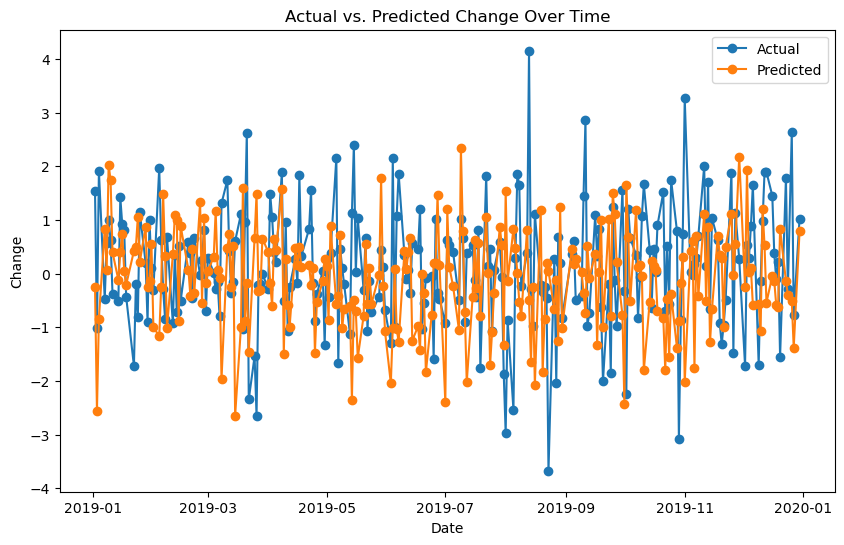

In [137]:
import matplotlib.pyplot as plt

# Assuming y_test is a DataFrame with 'Date' as the index and 'Change' as the column
# Replace 'Change' with the actual column name in your DataFrame
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test['Change'], label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='o')
plt.xlabel('Date')
plt.ylabel('Change')
plt.title('Actual vs. Predicted Change Over Time')
plt.legend()
plt.show()

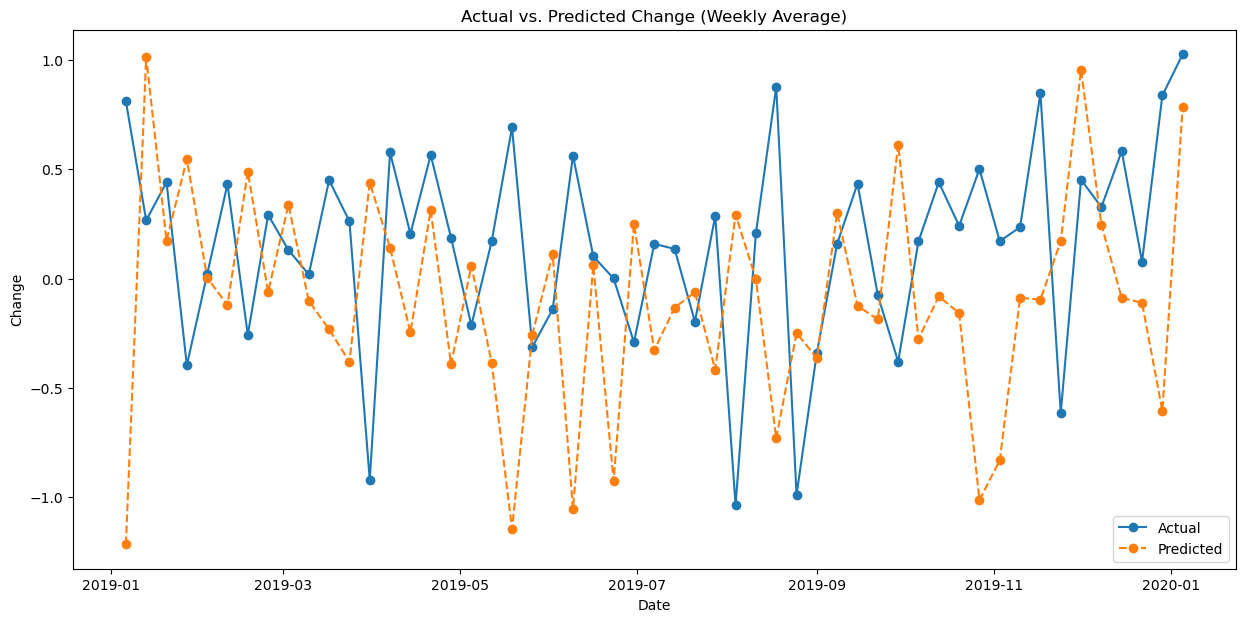

In [138]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y_test and y_pred are properly indexed by date
# If y_pred is not a DataFrame, convert it to one with the same index as y_test
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['Predicted'])

# Resample to weekly averages
y_test_resampled = y_test.resample('W').mean()
y_pred_resampled = y_pred_df.resample('W').mean()

plt.figure(figsize=(15, 7))
plt.plot(y_test_resampled.index, y_test_resampled['Change'], label='Actual', marker='o', linestyle='-')
plt.plot(y_pred_resampled.index, y_pred_resampled['Predicted'], label='Predicted', marker='o', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Change')
plt.title('Actual vs. Predicted Change (Weekly Average)')
plt.legend()
plt.show()

In [136]:
y_test

,Change
Date,
2019-01-02,1.540383
2019-01-03,-1.019362
2019-01-04,1.912129
2019-01-07,-0.477678
2019-01-08,0.563219
...,...
2019-12-23,1.774054
2019-12-24,-0.291809
2019-12-26,2.634382


In [132]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mse

2.4459998218945165